## Week 4, Lab 2: Predicting Chronic Kidney Disease in Patients
> Author: Matt Brems

We can sketch out the data science process as follows:
1. Define the problem.
2. Obtain the data.
3. Explore the data.
4. Model the data.
5. Evaluate the model.
6. Answer the problem.

In this lab, we're going to focus on steps exploring data, building models and evaluating the models we build.

There are three links you may find important:
- [A set of chronic kidney disease (CKD) data and other biological factors](./chronic_kidney_disease_full.csv).
- [The CKD data dictionary](./chronic_kidney_disease_header.txt).
- [An article comparing the use of k-nearest neighbors and support vector machines on predicting CKD](./chronic_kidney_disease.pdf).

## Step 1: Define the problem.

Suppose you're working for Mayo Clinic, widely recognized to be the top hospital in the United States. In your work, you've overheard nurses and doctors discuss test results, then arrive at a conclusion as to whether or not someone has developed a particular disease or condition. For example, you might overhear something like:

> **Nurse**: Male 57 year-old patient presents with severe chest pain. FDP _(short for fibrin degradation product)_ was elevated at 13. We did an echo _(echocardiogram)_ and it was inconclusive.

> **Doctor**: What was his interarm BP? _(blood pressure)_

> **Nurse**: Systolic was 140 on the right; 110 on the left.

> **Doctor**: Dammit, it's an aortic dissection! Get to the OR _(operating room)_ now!

> _(intense music playing)_

In this fictitious but [Shonda Rhimes-esque](https://en.wikipedia.org/wiki/Shonda_Rhimes#Grey's_Anatomy,_Private_Practice,_Scandal_and_other_projects_with_ABC) scenario, you might imagine the doctor going through a series of steps like a [flowchart](https://en.wikipedia.org/wiki/Flowchart), or a series of if-this-then-that steps to diagnose a patient. The first steps made the doctor ask what the interarm blood pressure was. Because interarm blood pressure took on the values it took on, the doctor diagnosed the patient with an aortic dissection.

Your goal, as a research biostatistical data scientist at the nation's top hospital, is to develop a medical test that can improve upon our current diagnosis system for [chronic kidney disease (CKD)](https://www.mayoclinic.org/diseases-conditions/chronic-kidney-disease/symptoms-causes/syc-20354521).

**Real-world problem**: Develop a medical diagnosis test that is better than our current diagnosis system for CKD.

**Data science problem**: Develop a medical diagnosis test that reduces both the number of false positives and the number of false negatives.

---

## Step 2: Obtain the data.

### 1. Read in the data.

In [1]:
import pandas as pd

In [2]:
ckd = pd.read_csv("../chronic_kidney_disease_full.csv")

In [3]:
ckd.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


### 2. Check out the data dictionary. What are a few features or relationships you might be interested in checking out?

**Answer:**
- First, I want to check the `ckd` variable to see if unbalanced classes would be an issue here. (A 38/62 split probably won't be problematic.)
- Secondly, since we want to predict `ckd`, I would probably want to compare each variable with `ckd` to see which variables appear to have predictive value.
- Next, I'll want to check the patterns of missingness. Are any variables missing extensively so that it will be problematic? Is there any missingness that is explained by the data dictionary? (i.e. tests not run due to certain thresholds being met?)
- Check out the distributions of each variable. Are there certain variables that overwhelmingly take on one value and thus might not be predictive?
- Lots of these variables have "blood" in the name. If I'm trying to do a linear model (i.e. logistic regression, linear regression), there might be some relationship among these features. (I'm not a doctor, so I'll err on the side of caution here!) If certain features are correlated, then I'll want to include interaction terms or I'll want to remove one of them when building a linear model.

---

## Step 3: Explore the data.

### 3. How much of the data is missing from each column?

In [4]:
ckd.isnull().sum()

age        9
bp        12
sg        47
al        46
su        49
rbc      152
pc        65
pcc        4
ba         4
bgr       44
bu        19
sc        17
sod       87
pot       88
hemo      52
pcv       71
wbcc     106
rbcc     131
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
class      0
dtype: int64

In [5]:
100 * ckd.isnull().sum() / ckd.shape[0]

age       2.25
bp        3.00
sg       11.75
al       11.50
su       12.25
rbc      38.00
pc       16.25
pcc       1.00
ba        1.00
bgr      11.00
bu        4.75
sc        4.25
sod      21.75
pot      22.00
hemo     13.00
pcv      17.75
wbcc     26.50
rbcc     32.75
htn       0.50
dm        0.50
cad       0.50
appet     0.25
pe        0.25
ane       0.25
class     0.00
dtype: float64

**Answer:** Some of the data is missing from every column except for `class`. In particular, `rbc`, `wbcc`, and `rbcc` are missing over 100 observations each. I'm particularly concerned about the categories that are missing over 15% of their data. This is problematic and should be addressed.

### 4. Suppose that I dropped every row that contained at least one missing value. (In the context of analysis with missing data, we call this a "complete case analysis," because we keep only the complete cases!) How many rows would remain in our dataframe? What are at least two downsides to doing this?

> There's a good visual on slide 15 of [this deck](https://liberalarts.utexas.edu/prc/_files/cs/Missing-Data.pdf) that shows what a complete case analysis looks like if you're interested.

In [6]:
ckd.dropna(axis = 0, how = 'any', inplace = False).shape

(158, 25)

In [7]:
ckd.dropna(axis = 0, how = 'any', inplace = False)['class'].value_counts()

notckd    115
ckd        43
Name: class, dtype: int64

**Answer:** We'd drop 242 of our 400 observations (over 60% of our data!) by dropping each row that contains any missing value. 

Some downsides to this:
- Of these 242 rows, many of them do have information filled in for some of the cells. If we drop any observation that contains at least one missing value, then I'm discarding a lot of data that exists!
- If "NaN" possibly means something (i.e. this test was not run), then discarding cells might be a bad idea. 
- By dropping values in this way, we drop 35 of our 150 "Not CKD" observations (23%) but drop 207 of our 250 "CKD" observations (83%!!!). This would affect the balance of our classes considerably and may create bias in our models.

Losing all of this data is inadvisable, so I will keep all of my data. (You may have made the choice to do a "complete-case analysis." While I personally would not do that here, you can! As a result, your answers below that rely on code may be different.)

### 5. Thinking critically about how our data were gathered, it's likely that these records were gathered by doctors and nurses. Brainstorm three potential areas (in addition to the missing data we've already discussed) where this data might be inaccurate or imprecise.

**Answer:** _(Answers may vary.)_

- Certain variables may be subjective. For example, two different doctors might arrive at two different conclusions for "appetite." What qualifies as "good" versus "poor?"
- For certain variables like "red blood cells," does it make sense to just leave it at "normal" versus "abnormal?" Are there multiple ways for red blood cells to be "abnormal?" This imprecision might make our test less effective than we'd like.
- While we assume this isn't the case, it's always possible that the data we have are wrong.
    - Maybe lab results were mixed up (i.e. not connected to the correct patient).
    - Maybe machines aren't properly calibrated or some contamination occurred so our measurements are incorrect.

---

## Step 4: Model the data.

### 6. Suppose that I want to construct a model where no person who has CKD will ever be told that they do not have CKD. What (very simple, no machine learning needed) model can I create that will never tell a person with CKD that they do not have CKD?

> Hint: Don't think about `statsmodels` or `scikit-learn` here.

**Answer:** An overly simplistic model would be to tell all people that they have CKD. Thus, no person would ever be told they do not have CKD.

### 7. In problem 6, what common classification metric did we optimize for? Did we minimize false positives or negatives?

**Answer:** In this problem, assuming that CKD is the "positive" class, **we minimized false negatives**. This is equivalent to **maximizing sensitivity**.

\[
\begin{align*}
\text{Sensitivity} &= \frac{\text{TP}}{\text{P}} \\
                   &= \frac{\text{TP}}{\text{TP + FN}} \\
\Rightarrow 1 &= \frac{\text{TP}}{\text{TP + FN}} \\
\Rightarrow \text{TP + FN} &= \text{TP} \\
\Rightarrow \text{FN} &= 0 \\
\end{align*}
\]

### 8. Thinking ethically, what is at least one disadvantage to the model you described in problem 6?

**Answer:** _(Answers may vary.)_

Telling every person they have CKD is unethical because then people will likely pursue expensive treatment options. It also causes lots of anxiety. In the long run, people would stop using your test because of all of the false positives.

### 9. Suppose that I want to construct a model where a person who does not have CKD will ever be told that they do have CKD. What (very simple, no machine learning needed) model can I create that will accomplish this?

**Answer:** An overly simplistic model would be to tell no people that they have CKD. Thus, no person would ever be told they do have CKD.

### 10. In problem 9, what common classification metric did we optimize for? Did we minimize false positives or negatives?

**Answer:** In this problem, assuming that CKD is the "positive" class, **we minimized false positives**. This is equivalent to **maximizing specificity**.

$$
\begin{eqnarray*}
\text{Specificity} &=& \frac{\text{TN}}{\text{N}} \\
&=& \frac{\text{TN}}{\text{TN + FP}} \\
\Rightarrow 1 &=& \frac{\text{TN}}{\text{TN + FP}} \\
\Rightarrow \text{TN + FP} &=& \text{TN} \\
\Rightarrow \text{FP} &=& 0 \\
\end{eqnarray*}
$$

### 11. Thinking ethically, what is at least one disadvantage to the model you described in problem 9?

**Answer:** _(Answers may vary.)_

Telling every person they do not have CKD is unethical because then people will return home thinking they are healthy when they are not. This would likely result in deaths of patients. Additionally, in the long run, people would stop using your test because of all of the false negatives.

### 12. Construct a logistic regression model in `sklearn` predicting class from the other variables. You may scale, select/drop, and engineer features as you wish - build a good model! Make sure, however, that you include at least one categorical/dummy feature and at least one quantitative feature.

> Hint: Remember to do a train/test split!

In [8]:
ckd.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


In [9]:
ckd['y'] = [1 if i == 'ckd' else 0 for i in ckd['class']]

In [10]:
ckd['y'].value_counts()

1    250
0    150
Name: y, dtype: int64

I want to create interaction terms in cases where variables may be correlated (I'm not a doctor, but pus cell and pus cell clumps are probably related, right? Same with red and white blood cell counts.)
- PC and PCC
- WBCC and RBCC

In [11]:
ckd['pc_pcc_interaction'] = [1 if ckd.loc[i, 'pc'] == 'abnormal' and ckd.loc[i, 'pcc'] == 'present' else 0 for i in range(len(ckd['pc']))]

In [12]:
ckd['wbcc_rbcc_interaction'] = ckd['wbcc'] * ckd['rbcc']

I don't have great subject-matter expertise for removing anything. Thus, I'm going to include all of my variables (including the interaction terms I just created), then consider dropping some if there's evidence of overfitting.

In [13]:
ckd.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,htn,dm,cad,appet,pe,ane,class,y,pc_pcc_interaction,wbcc_rbcc_interaction
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,yes,yes,no,good,no,no,ckd,1,0,40560.0
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,no,no,no,good,no,no,ckd,1,0,NaN
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,no,yes,no,poor,no,yes,ckd,1,0,NaN
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,yes,no,no,poor,yes,yes,ckd,1,1,26130.0
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,no,no,no,good,no,no,ckd,1,0,33580.0


In [14]:
ckd.columns

Index(['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu',
       'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc', 'htn', 'dm', 'cad',
       'appet', 'pe', 'ane', 'class', 'y', 'pc_pcc_interaction',
       'wbcc_rbcc_interaction'],
      dtype='object')

In [15]:
ckd.dtypes

age                      float64
bp                       float64
sg                       float64
al                       float64
su                       float64
rbc                       object
pc                        object
pcc                       object
ba                        object
bgr                      float64
bu                       float64
sc                       float64
sod                      float64
pot                      float64
hemo                     float64
pcv                      float64
wbcc                     float64
rbcc                     float64
htn                       object
dm                        object
cad                       object
appet                     object
pe                        object
ane                       object
class                     object
y                          int64
pc_pcc_interaction         int64
wbcc_rbcc_interaction    float64
dtype: object

In [16]:
rbc_abnormal = pd.get_dummies(ckd['rbc'])['abnormal']

In [17]:
pc_abnormal = pd.get_dummies(ckd['pc'])['abnormal']

In [18]:
pcc_present = pd.get_dummies(ckd['pcc'])['present']

In [19]:
ba_present = pd.get_dummies(ckd['ba'])['present']

In [20]:
htn_yes = pd.get_dummies(ckd['htn'])['yes']

In [21]:
dm_yes = pd.get_dummies(ckd['dm'])['yes']

In [22]:
cad_yes = pd.get_dummies(ckd['cad'])['yes']

In [23]:
appet_poor = pd.get_dummies(ckd['appet'])['poor']

In [24]:
pe_yes = pd.get_dummies(ckd['pe'])['yes']

In [25]:
ane_yes = pd.get_dummies(ckd['ane'])['yes']

I'm going to set all of my dummy variables up in a dataframe called `qual` (for qualitative) and all my quantitative variables in a dataframe called `quant` (for quantitative).

In [26]:
quant = ckd[['age', 'bp', 'sg', 'al', 'su', 'bgr',
                 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv',
                 'wbcc', 'rbcc', 'pc_pcc_interaction',
                 'wbcc_rbcc_interaction']]

qual = pd.DataFrame([ane_yes, pe_yes, rbc_abnormal, pc_abnormal,
                     pcc_present, ba_present, htn_yes, dm_yes,
                     cad_yes, appet_poor], index=['ane_yes', 'pe_yes', 'rbc_abnormal',
                                                  'pc_abnormal', 'pcc_present',
                                                  'ba_present', 'htn_yes', 'dm_yes',
                                                  'cad_yes', 'appet_poor']).T

In [27]:
X = quant.merge(right = qual, left_index = True, right_index = True)

In [28]:
X

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,...,ane_yes,pe_yes,rbc_abnormal,pc_abnormal,pcc_present,ba_present,htn_yes,dm_yes,cad_yes,appet_poor
0,48.0,80.0,1.020,1.0,0.0,121.0,36.0,1.2,NaN,NaN,...,0,0,0,0,0,0,1,1,0,0
1,7.0,50.0,1.020,4.0,0.0,NaN,18.0,0.8,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,62.0,80.0,1.010,2.0,3.0,423.0,53.0,1.8,NaN,NaN,...,1,0,0,0,0,0,0,1,0,1
3,48.0,70.0,1.005,4.0,0.0,117.0,56.0,3.8,111.0,2.5,...,1,1,0,1,1,0,1,0,0,1
4,51.0,80.0,1.010,2.0,0.0,106.0,26.0,1.4,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,140.0,49.0,0.5,150.0,4.9,...,0,0,0,0,0,0,0,0,0,0
396,42.0,70.0,1.025,0.0,0.0,75.0,31.0,1.2,141.0,3.5,...,0,0,0,0,0,0,0,0,0,0
397,12.0,80.0,1.020,0.0,0.0,100.0,26.0,0.6,137.0,4.4,...,0,0,0,0,0,0,0,0,0,0
398,17.0,60.0,1.025,0.0,0.0,114.0,50.0,1.0,135.0,4.9,...,0,0,0,0,0,0,0,0,0,0


In [29]:
# NOTE: We are using L1/L2 regularization below.
#   Because regularization depends on the scale of the coefficients,
#    we should use `StandardScalar` on our data.
#
# However, in this case that results in a perfect model on this split,
#   which makes the resulting analysis less insightful.
#
# So, for pedagogical purposes, we will refrain from scaling for now.

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

I ran into a lot of data munging issues with `X`. The NAs in the dataframe were throwing it off. I decided to take a **very** rudimentary approach by filling in the mean.

### NOTE: FILLING IN THE MEAN IS USUALLY CATASTROPHIC FOR YOUR ANALYSIS. We will learn proper methods of imputation later in the class. This quick fix leads to lots negative side effects, especially if you're attempting to conduct inference. I am using this quick fix so as to not distract from the point of the lab, but using mean imputation is inadvisable in most circumstances. *Proceed with caution.*

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X.fillna(X.mean()),
                                                    ckd['y'],
                                                    test_size = 0.3, 
                                                    random_state = 42)

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [32]:
parameters = {'C': [0.001, 0.01, 0.1, 1, 10],
              'class_weight': [None, 'balanced'],
              'penalty': ['l1', 'l2']}

In [33]:
import random
random.seed(42)

# We are testing l1 and l2 penalties in GridSearch.
# The default solver 'lbfgs' only supports l2, so we're switching to 'liblinear' instead.
lr = LogisticRegression(solver = 'liblinear', 
                        max_iter = 1000,
                        random_state = 42)

gs_results = GridSearchCV(estimator = lr,                                    # Specify the model we want to GridSearch.
                          param_grid = parameters,                           # Specify the grid of parameters we want to search.
                          scoring = 'recall',                                # Specify recall as the metric to optimize 
                          cv = 5).fit(X_train, y_train)                      # Set 5-fold cross-validation, then fit. (Default is 3.)

In [34]:
gs_results.best_estimator_.get_params()

{'C': 1,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Based on the results of this GridSearch, our best model is that which:
- Has an inverse regularization strength of $C = 10$.
- Balances our `class_weight` (weighting our `y` variables so each class makes up 50%).
- Has the `L2` penalty (i.e. Ridge regression).

In [35]:
logit = LogisticRegression(solver = 'liblinear', 
                           max_iter = 1000,
                           C = 10,
                           class_weight = 'balanced',
                           penalty = 'l2',
                           random_state = 42)

In [36]:
logit.fit(X = X_train,
          y = y_train)

LogisticRegression(C=10, class_weight='balanced', max_iter=1000,
                   random_state=42, solver='liblinear')

In [37]:
logit.score(X_train, y_train)

0.9857142857142858

In [38]:
logit.score(X_test, y_test)

0.975

---

## Step 5: Evaluate the model.

### 13. Based on your logistic regression model constructed in problem 12, interpret the coefficient of one of your quantitative features.

In [39]:
import numpy as np

In [40]:
list(zip(np.exp(logit.coef_[0]),X.columns))

[(1.0104021833165564, 'age'),
 (1.1216599206175084, 'bp'),
 (1.1864794991899943, 'sg'),
 (30.26413215202686, 'al'),
 (2.8496519397957525, 'su'),
 (1.0380456965011602, 'bgr'),
 (0.9267777635255748, 'bu'),
 (11.858475667682171, 'sc'),
 (1.0676964186094844, 'sod'),
 (1.333722148265059, 'pot'),
 (0.18912369888809827, 'hemo'),
 (1.0031159318987533, 'pcv'),
 (0.999620250490188, 'wbcc'),
 (0.3545833082927995, 'rbcc'),
 (1.067200775300398, 'pc_pcc_interaction'),
 (1.0000744806274964, 'wbcc_rbcc_interaction'),
 (1.6306381039004674, 'ane_yes'),
 (5.50669518513279, 'pe_yes'),
 (2.07525415663176, 'rbc_abnormal'),
 (1.956457100154428, 'pc_abnormal'),
 (1.0833393645225249, 'pcc_present'),
 (1.0238342490893528, 'ba_present'),
 (4.208108844047649, 'htn_yes'),
 (4.087981646669618, 'dm_yes'),
 (1.0601640784708677, 'cad_yes'),
 (4.64782663314551, 'appet_poor')]

**Answer:** As serum creatinine (`sc`) increases by one unit (mgs/dl), an individual is 11.85 times as likely to have CKD, all else held equal.
- Note that I exponentiated the coefficients!

### 14. Based on your logistic regression model constructed in problem 12, interpret the coefficient of one of your categorical/dummy features.

In [41]:
list(zip(np.exp(logit.coef_[0]),X.columns))

[(1.0104021833165564, 'age'),
 (1.1216599206175084, 'bp'),
 (1.1864794991899943, 'sg'),
 (30.26413215202686, 'al'),
 (2.8496519397957525, 'su'),
 (1.0380456965011602, 'bgr'),
 (0.9267777635255748, 'bu'),
 (11.858475667682171, 'sc'),
 (1.0676964186094844, 'sod'),
 (1.333722148265059, 'pot'),
 (0.18912369888809827, 'hemo'),
 (1.0031159318987533, 'pcv'),
 (0.999620250490188, 'wbcc'),
 (0.3545833082927995, 'rbcc'),
 (1.067200775300398, 'pc_pcc_interaction'),
 (1.0000744806274964, 'wbcc_rbcc_interaction'),
 (1.6306381039004674, 'ane_yes'),
 (5.50669518513279, 'pe_yes'),
 (2.07525415663176, 'rbc_abnormal'),
 (1.956457100154428, 'pc_abnormal'),
 (1.0833393645225249, 'pcc_present'),
 (1.0238342490893528, 'ba_present'),
 (4.208108844047649, 'htn_yes'),
 (4.087981646669618, 'dm_yes'),
 (1.0601640784708677, 'cad_yes'),
 (4.64782663314551, 'appet_poor')]

**Answer:** If someone's appetite is poor `appet_poor`, they are 4.64 times as likely to have CKD, all else held equal.
- Note that I exponentiated the coefficients!

### 15. Despite being a relatively simple model, logistic regression is very widely used in the real world. Why do you think that's the case? Name at least two advantages to using logistic regression as a modeling technique.

**Answer:** _(Answers may vary.)_

- Logistic regression allows for interpretable coefficients so that we can understand how `X` affects `y`, as we saw above.
- Logistic regression usually does not suffer from high variance due to the large number of simplifying assumptions placed on the model. (i.e. features are "linear in the logit," errors are independent and follow a Bernoulli distribution, etc.)

### 16. Does it make sense to generate a confusion matrix on our training data or our test data? Why? Generate it on the proper data.

> Hint: Once you've generated your predicted $y$ values and you have your observed $y$ values, then it will be easy to [generate a confusion matrix using sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

In [42]:
y_preds = logit.predict(X_test)

**Answer:** It makes more sense to generate a confusion matrix on our **test data**, as that provides a proper evaluation of our methods.

In [43]:
from sklearn.metrics import confusion_matrix

In [44]:
confusion_matrix(y_test, y_preds)

array([[43,  1],
       [ 2, 74]])

In [45]:
tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()

In [46]:
print("True Negatives: " + str(tn))
print()
print("False Positives: " + str(fp))
print()
print("False Negatives: " + str(fn))
print()
print("True Positives: " + str(tp))

True Negatives: 43

False Positives: 1

False Negatives: 2

True Positives: 74


### 17. In this hospital case, we want to predict CKD. Do we want to optimize for sensitivity, specificity, or something else? Why? (If you don't think there's one clear answer, that's okay! There rarely is. Be sure to defend your conclusion!)

**Answer:** _(Answers may vary.)_

We probably want to find some combination of sensitivity and specificity. 
- Focusing only on sensitivity means we minimize false negatives. This means there will be few people we incorrectly predict to be healthy, but more people we incorrectly predict to be sick.
- Focusing only on specificity means we minimize false positives. This means there will be few people we incorrectly predict to be sick, but more people we incorrectly predict to be healthy.

I don't think sensitivity and specificity are equally important, though. I think sensitivity is more important (I'd rather tell people they have CKD and be wrong than tell people they're healthy and have them get sick.).

Four potential options I would consider in this case:
- Just go with optimizing sensitivity, as it's better than optimizing specificity.
- I might try to optimize `f1-score`, a combination of sensitivity and specificity.
- I might try to optimize a custom metric that weighs sensitivity somewhat more importantly than specificity.
- I might look at my ROC curve and try to find a place where sensitivity is very high and 1 - specificity is pretty low.

### 18. Write a function that will create an ROC curve for you, then plot the ROC curve.

Here's a strategy you might consider:
1. In order to even begin, you'll need some fit model. Use your logistic regression model from problem 12.
2. We want to look at all values of your "threshold" - that is, anything where .predict() gives you above your threshold falls in the "positive class," and anything that is below your threshold falls in the "negative class." Start the threshold at 0.
3. At this value of your threshold, calculate the sensitivity and specificity. Store these values.
4. Increment your threshold by some "step." Maybe set your step to be 0.01, or even smaller.
5. At this value of your threshold, calculate the sensitivity and specificity. Store these values.
6. Repeat steps 3 and 4 until you get to the threshold of 1.
7. Plot the values of sensitivity and 1 - specificity.

In [47]:
import matplotlib.pyplot as plt

%matplotlib inline

In [48]:
def roc(probas, true, step=0.01):
    """
    probas should be a numpy array of predict_probas
    true is a pandas series of true labels
    step is the step size for checking thresholds
    """
    
    probas = probas[:,1]  # The output of predict_proba() is an array of the probabilities for every class, but we only want the probabilities for class 1
    true = true.values    # We need to convert the class labels from a Pandas Series to a numpy array. We do this using the .values attribute
    assert(len(probas) == len(true)) # We're making sure that our probabilities vector is the same length as our true class labesl vector
    
    TPRs = [] # Setting up empty list of True Positive Rate
    FPRs = [] # Setting up empty list of False Positive Rate
    
    for i in np.arange(0.0,1.0,step): # np.arange allows us to use step sizes that are decimals
        preds_class = probas > i # Numpy arrays have a feature called 'broadcasting.' Check the documentation: https://docs.scipy.org/doc/numpy-1.13.0/user/basics.broadcasting.html to see what this does.
        TP = 0 
        FP = 0
        TN = 0
        FN = 0
        for index in range(len(preds_class)): # We're comparing each prediction with each true value here

            if preds_class[index] == 1 and true[index] == 1:
                TP += 1
            elif preds_class[index] == 1 and true[index] == 0:
                FP += 1
            elif preds_class[index] == 0 and true[index] == 0:
                TN += 1 
            elif preds_class[index] == 0 and true[index] == 1:
                FN += 1
                
        TPR = TP/(TP + FN) # Calculating TPR and FPR and appending to our lists
        FPR = FP/(FP + TN)
        
        TPRs.append(TPR)
        FPRs.append(FPR)
         
    plt.rcParams['font.size'] = 14
    plt.plot(FPRs, TPRs, color="orange")
    plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('Receiver Operating Characteristic')
    plt.xlabel("False Positive Rate (1 - Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.show();

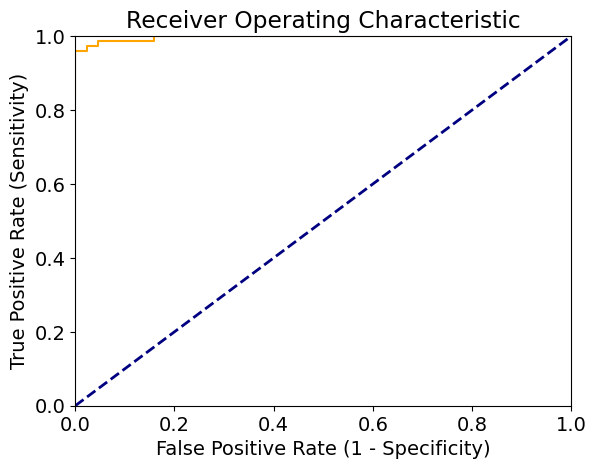

In [49]:
probabilities = logit.predict_proba(X_test)

roc(probas = probabilities, # pass in series of probabilities 
    true = y_test,          # pass in series of true values
    step=0.001);            # pass in step size

### 19. Suppose you're speaking with the biostatistics lead at Mayo Clinic, who asks you "Why are unbalanced classes generally a problem? Are they a problem in this particular CKD analysis?" How would you respond?

**Answer:** _(Answers may vary.)_
- Unbalanced classes are usually a problem because our model has a tough time learning about the minority class. There's simply not enough data to learn the "pattern" or "behavior" of the minority class.
- They probably aren't a problem in this CKD analysis. A 40/60 split isn't substantially unbalanced. However, in gridsearching over whether or not to balance our classes, GridSearchCV found that our model performs better when we balance our `y` classes.

### 20. Suppose you're speaking with a doctor at Mayo Clinic who, despite being very smart, doesn't know much about data science or statistics. How would you explain why unbalanced classes are generally a problem to this doctor?

**Answer:** _(Answers may vary.)_

Let's say you treat a patient who comes in with a broken arm. These happen pretty frequently, so you have a good idea of how to fix it, what potential complications are, etc. On the other hand, let's say you treat a patient who presents with odd symptoms that you've never seen before. You check books and do research, but it's very hard to understand this disease becauses you just don't have enough information to identify causes or recommend treatments.

That is the problem of unbalanced classes. When we build a model where we have lots of broken arms but very few "rare diseases," it's hard for our model to learn about those rare diseases because we see them so infrequently that we don't have enough information.

> This type of skill - explaining things to a non-technical audience - is a very important skill to have. Practice honing this skill as much as you can! Whether you're in an interview with a non-technical peer or you have a phone screen with [Linda from human resources](https://www.youtube.com/watch?v=31rjM7_wKoE), you want to be able to explain technical topics to non-technical people. (Like your capstone!)

### 21. Let's create very unbalanced classes just for the sake of this example! Generate very unbalanced classes by [bootstrapping](http://stattrek.com/statistics/dictionary.aspx?definition=sampling_with_replacement) (a.k.a. random sampling with replacement) the majority class.

1. The majority class are those individuals with CKD.
2. Generate a random sample of size 200,000 of individuals who have CKD with replacement. (Consider setting a random seed for this part!)
3. Create a new dataframe with the original data plus this random sample of data.
4. Now we should have a dataset with around 200,000 observations, of which only about 0.00075% are non-CKD individuals.

Note: You may have fewer than 200,000 observations if you chose to drop missing values above!

In [50]:
ckd_sample = ckd[ckd['class'] == 'ckd'].sample(200_000,            # sample n = 200,000
                                               replace = True,     # sample with replacement
                                               random_state = 42)  # set random state

In [51]:
ckd_2 = pd.concat([ckd, ckd_sample])

In [52]:
ckd_2.shape

(200400, 28)

In [53]:
ckd_2.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,htn,dm,cad,appet,pe,ane,class,y,pc_pcc_interaction,wbcc_rbcc_interaction
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,yes,yes,no,good,no,no,ckd,1,0,40560.0
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,no,no,no,good,no,no,ckd,1,0,NaN
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,no,yes,no,poor,no,yes,ckd,1,0,NaN
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,yes,no,no,poor,yes,yes,ckd,1,1,26130.0
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,no,no,no,good,no,no,ckd,1,0,33580.0


In [54]:
100 * ckd_2['class'].value_counts() / len(ckd_2['class'])

ckd       99.92515
notckd     0.07485
Name: class, dtype: float64

### 22. Build a logistic regression model on the unbalanced class data and evaluate its performance using whatever method(s) you see fit. How would you describe the impact of unbalanced classes on logistic regression as a classifier?

For this model, I'm not going to artificially balance the classes. I **want** to see the impact of unbalanced classes on my model.

In [55]:
quant = ckd_2[['age', 'bp', 'sg', 'al', 'su', 'bgr',
                 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv',
                 'wbcc', 'rbcc', 'pc_pcc_interaction',
                 'wbcc_rbcc_interaction', 'y']].copy()     # Since we are modifying the df, copy it!

quant.loc[:,'rbc_abnormal_2'] = pd.get_dummies(ckd_2['rbc'])['abnormal']
quant.loc[:,'pc_abnormal_2'] = pd.get_dummies(ckd_2['pc'])['abnormal']
quant.loc[:,'pcc_present_2'] = pd.get_dummies(ckd_2['pcc'])['present']
quant.loc[:,'ba_present_2'] = pd.get_dummies(ckd_2['ba'])['present']
quant.loc[:,'htn_yes_2'] = pd.get_dummies(ckd_2['htn'])['yes']
quant.loc[:,'dm_yes_2'] = pd.get_dummies(ckd_2['dm'])['yes']
quant.loc[:,'cad_yes_2'] = pd.get_dummies(ckd_2['cad'])['yes']
quant.loc[:,'appet_poor_2'] = pd.get_dummies(ckd_2['appet'])['poor']
quant.loc[:,'pe_yes_2'] = pd.get_dummies(ckd_2['pe'])['yes']
quant.loc[:,'ane_yes_2'] = pd.get_dummies(ckd_2['ane'])['yes']

In [56]:
quant.head()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,...,rbc_abnormal_2,pc_abnormal_2,pcc_present_2,ba_present_2,htn_yes_2,dm_yes_2,cad_yes_2,appet_poor_2,pe_yes_2,ane_yes_2
0,48.0,80.0,1.020,1.0,0.0,121.0,36.0,1.2,NaN,NaN,...,0,0,0,0,1,1,0,0,0,0
1,7.0,50.0,1.020,4.0,0.0,NaN,18.0,0.8,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,62.0,80.0,1.010,2.0,3.0,423.0,53.0,1.8,NaN,NaN,...,0,0,0,0,0,1,0,1,0,1
3,48.0,70.0,1.005,4.0,0.0,117.0,56.0,3.8,111.0,2.5,...,0,1,1,0,1,0,0,1,1,1
4,51.0,80.0,1.010,2.0,0.0,106.0,26.0,1.4,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [57]:
quant.shape

(200400, 27)

In [58]:
quant.columns

Index(['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo',
       'pcv', 'wbcc', 'rbcc', 'pc_pcc_interaction', 'wbcc_rbcc_interaction',
       'y', 'rbc_abnormal_2', 'pc_abnormal_2', 'pcc_present_2', 'ba_present_2',
       'htn_yes_2', 'dm_yes_2', 'cad_yes_2', 'appet_poor_2', 'pe_yes_2',
       'ane_yes_2'],
      dtype='object')

In [59]:
X_train, X_test, y_train, y_test = train_test_split(quant.fillna(quant.mean()).drop(['y'],
                                                                                    axis = 1),
                                                    quant['y'],
                                                    test_size = 0.3, 
                                                    random_state = 42)

In [60]:
logit_2 = LogisticRegression(solver = 'liblinear',   # to compare with before
                             max_iter = 1000,
                             C = 10,
                             random_state = 42,
                             penalty = 'l2')

In [61]:
logit_2.fit(X_train, y_train)

LogisticRegression(C=10, max_iter=1000, random_state=42, solver='liblinear')

In [62]:
from sklearn.metrics import classification_report

In [63]:
print(classification_report(y_test,
                            logit_2.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.62      0.77        56
           1       1.00      1.00      1.00     60064

    accuracy                           1.00     60120
   macro avg       1.00      0.81      0.88     60120
weighted avg       1.00      1.00      1.00     60120



**Answer:** _(Answers may vary.)_

I'm comparing my models based on **sensitivity**. Sensitivity is also known as **recall** or the **true positive rate**.

- In this case, my sensitivity score (true positives / all positives) is 100%.
- Earlier, the logistic regression model fit on my more balanced data had a sensitivity of 74 / 76, or about 93%.

In this case, it seems as though unbalanced classes actually makes our model perform **better**. This will usually not happen. However, let's think through unbalanced classes.

- The problem with unbalanced classes is that our algorithms have trouble learning the patterns in the minority class. There usually isn't enough data to learn what causes the minority class.
- In the case of predicting CKD, it's likely that a handful of factors will predict CKD. It's unlikely that 10 different variables contribute to detecting CKD. Maybe we only need a small amount of data ($n = 150$) to identify CKD. We could test this theory by undersampling the CKD group to be like $n = 20$ or $n = 30$. 
- On the other hand, the majority class is probably quite diverse. Different people will have lots of different levels of all of these variables. Augmenting the majority class won't necessarily add noise to our model.
- Thus, if we have enough data in our minority class to detect CKD, then we our model won't necessarily be biased!

Note that we also wouldn't likely just want to compare models on one metric, like sensitivity. Using multiple metrics to compare these models may be warranted - and in a case where we're dealing with humans and disease, it's very important to consider any of the downsides of optimizing only one metric!

---

## Step 6: Answer the problem.


- At this step, you would generally answer the problem! In this situation, you would likely present your model to doctors or administrators at the hospital and show how your model results in reduced false positives/false negatives. Next steps would be to find a way to roll this model and its conclusions out across the hospital so that the outcomes of patients with CKD (and without CKD!) can be improved!